# 2018-11-15 Tuning curve based on entry, not LGN-V1 connectivity
Voir le distinguo 2018-11-12

On présente un motioncloud qui change d'orientation (de 0 a pi) et on calcule le courant pour 4 theta, celui qui nous intéresse étant le theta à pi/3

# TODO : Rerun at home for faster computations

In [1]:
import numpy as np
import Spiking_LGN as SpiLGN
import MotionClouds as mc

In [13]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel
from tqdm import tqdm

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

gain = .4
injection_sampling_rate = 1
fr_list = []

for mc_theta in tqdm(np.linspace(0, np.pi, 12)):
    fx, fy, ft = mc.get_grids(64, 64, 128)
    envelope = mc.envelope_gabor(fx, fy, ft,
                                 V_X=1., V_Y=0., B_V=.1,
                                 sf_0=.15, B_sf=.1,
                                 theta=np.pi/3, B_theta=np.pi/12, alpha=1.)
    movie = mc.random_cloud(envelope)
    movie = mc.rectif(movie)
    
    output_currents = SpiLGN.input_to_currents(video=movie, FPS=24., total_time=1000,
                                           distrib_size=8, safeguard_offset=12, random_shift=1, grid_res=3,
                                           N_theta=4, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 2,
                                           n_jobs=-1, backend='loky', mt_verbose=0,
                                              verbose = False)
    load_arr = output_currents
    
    total_time = len(load_arr[0][0][0][0])
    current_levels = load_arr[1][3] #second theta approx. 60 degrees and third gabor to be safe
    current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)
    
    ##############
    # Simulation #
    ##############
    sim.setup(timestep=0.1)

    post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


    #injecting all ON cells current
    for inputs in range(len(current_levels[0])):

        current_level = current_levels[0][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = current_level*gain)
        current_input.inject_into(post)
        current_input.record()

    #injecting all OFF cells current
    for inputs in range(len(current_levels[1])):

        current_level = current_levels[1][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = current_level*gain)
        current_input.inject_into(post)
        current_input.record()

    post.record(['spikes', 'v'])

    sim.run(total_time)
    sim.end()

    #PLOTTING and DATA
    post_v = post.get_data().segments[0]
    sig = post_v.analogsignals[0]

    beg = 200 # we have an initialisation firing that causes problems so we remove the first 200 ms

    non_init_times = post_v.spiketrains[0].times > beg
    non_init_spikes = np.asarray(post_v.spiketrains[0])*non_init_times
    non_init_spikes = np.nonzero(non_init_spikes)[0]
    
    fr = non_init_spikes.shape[0]*1000/800

    fr_list.append(fr)


  0%|          | 0/12 [00:00<?, ?it/s]

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.

  8%|▊         | 1/12 [07:07<1:18:18, 427.12s/it]


 17%|█▋        | 2/12 [13:58<1:09:52, 419.25s/it]


 25%|██▌       | 3/12 [20:34<1:01:43, 411.53s/it]


 33%|███▎      | 4/12 [27:15<54:30, 408.85s/it]  


 42%|████▏     | 5/12 [33:51<47:23, 406.25s/it]


 50%|█████     | 6/12 [40:37<40:37, 406.30s/it]


 58%|█████▊    | 7/12 [47:15<33:45, 405.13s/it]


 67%|██████▋   | 8/12 [53:52<26:56, 404.06s/it]


 75%|███████▌  | 9/12 [1:00:29<20:09, 403.29s/it]


 83%|████████▎ | 10/12 [2:36:43<31:20, 940.37s/it]


 92%|█████████▏| 11/12 [2:43:57<14:54, 894.31s/it]


100%|██████████| 12/12 [2:51:26<00:00, 857.17s/it]


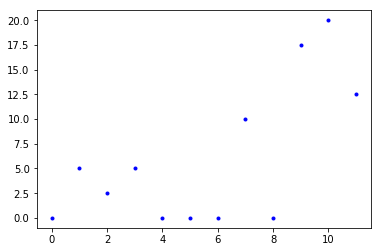

In [17]:
import matplotlib.pyplot as plt
plt.plot(fr_list, '.b')